In [1]:
import os
import sys
import glob
import yaml
import pickle
import random
import sys
sys.path.append('../../')
from src import utils
import numpy as np
import pandas as pd
import scipy.stats as stats
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler, LabelEncoder

import json
import wandb

In [2]:
# config
with open('config.yaml') as f:
    config = yaml.safe_load(f)

# globals variable
SEED = config['globals']['seed']
N_SPLITS = config['globals']['n_splits']
USE_FOLDS = config['globals']['use_folds']
DEBUG = config['globals']['debug']
EXP_MESSAGE = config['globals']['exp_message']
NOTES = config['globals']['notes']
MODEL_SAVE = config['globals']['model_save']
ONLY_PRED = config['globals']['only_pred']
PRETRAINED = config['globals']['pretrained']
PRETRAINED_PATH = config['globals']['pretrained_path']
EXP_NAME = str(Path().resolve()).split('/')[-1]
utils.seed_everything(SEED)

EXP_NAME = str(Path().resolve()).split('/')[-1]

In [3]:
EXP_NAME

'exp008'

In [4]:
!wandb login 1bb2d0449c11d8b987e25c38b9d8dda176310fb6

wandb: Appending key for api.wandb.ai to your netrc file: /home/user/.netrc


In [5]:
# waypointを補正したdataset
root_dir = Path('../../input/')
train_df = pd.read_csv(root_dir / "baseline_locations_train.csv")
test_df = pd.read_csv(root_dir / "baseline_locations_test.csv")
sub_df = pd.read_csv(root_dir / 'sample_submission.csv', index_col=0)


In [6]:
# train_df = train_df[~train_df['collectionName'].isin([
#     '2020-08-03-US-MTV-1',
#     '2020-08-06-US-MTV-2',
#     '2020-07-17-US-MTV-1',
#     '2020-07-17-US-MTV-2'])].reset_index(drop=True)

In [7]:
train_df.shape, test_df.shape

((131342, 7), (91486, 7))

In [8]:
import glob
import os
from tqdm.notebook import tqdm


def get_ground_truth(args):
    (collectionName, phoneName), df = args
    
    path = root_dir / f"train/{collectionName}/{phoneName}/ground_truth.csv"
    target_df = pd.read_csv(path)
    output_df = pd.DataFrame()
    # merge derived and target by 'millisSinceGpsEpoch'
    for epoch, epoch_df in df.groupby('millisSinceGpsEpoch'):
        idx = (target_df['millisSinceGpsEpoch'] - epoch).abs().argmin()
        epoch_diff = epoch - target_df.loc[idx, 'millisSinceGpsEpoch']
        epoch_df['epoch_diff'] = epoch_diff
        epoch_df['target_latDeg'] = target_df.loc[idx, 'latDeg']
        epoch_df['target_lngDeg'] = target_df.loc[idx, 'lngDeg']
        output_df = pd.concat([output_df, epoch_df]).reset_index(drop=True)    
    return output_df

In [9]:
# metric
def calc_haversine(lat1, lon1, lat2, lon2):
    """Calculates the great circle distance between two points
    on the earth. Inputs are array-like and specified in decimal degrees.
    """
    RADIUS = 6_367_000
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    dist = 2 * RADIUS * np.arcsin(a**0.5)
    
    angle = np.degrees(np.arctan2(dlat, dlon))  # radian -> degree
    return dist, angle

In [10]:
import multiprocessing

processes = multiprocessing.cpu_count()
with multiprocessing.Pool(processes=processes) as pool:
    gr = train_df.groupby(['collectionName','phoneName'])
    dfs = pool.imap_unordered(get_ground_truth, gr)
    dfs = tqdm(dfs, total=len(gr))
    dfs = list(dfs)
train_df = pd.concat(dfs).sort_values(['collectionName', 'phoneName', 'millisSinceGpsEpoch'])

  0%|          | 0/73 [00:00<?, ?it/s]

In [11]:
def linear_interpolation(input_df):
    dfs = pd.DataFrame()
    for (collectionName, phoneName), df in input_df.groupby(['collectionName','phoneName']):
        df = df.sort_values("millisSinceGpsEpoch")
        assert len(df)==df["millisSinceGpsEpoch"].nunique()
 
        df['delta'], _ = calc_haversine(df['latDeg'], df['lngDeg'], df['latDeg'].shift(1), df['lngDeg'].shift(1))
        df['time_delta'] = df['millisSinceGpsEpoch'] - df['millisSinceGpsEpoch'].shift(1)
        df['delta'].fillna(0, inplace=True)
        df['time_delta'].fillna(0, inplace=True)
        df['speed'] = df['delta'] / (df['time_delta']/1000)  # m/s
        df['speed'].fillna(0, inplace=True)

        # 一度欠損値にする
        df.loc[50<df['speed'], ['latDeg', 'lngDeg']] = np.nan
        df['dummy_datetime'] = pd.to_datetime(df['millisSinceGpsEpoch'])
        df = df.set_index('dummy_datetime')

        # 時間に合わせて線形補間
        df = df.interpolate(method='time').reset_index(drop=True)
        dfs = pd.concat([dfs, df]).reset_index(drop=True)
    return dfs

In [12]:
train_df = linear_interpolation(train_df)

In [20]:
def get_delta(input_df, contain_target=False):
    output_df = pd.DataFrame()
    for (collection_name, phone_name), df in tqdm(input_df.groupby(['collectionName', 'phoneName'])):
        df = df.sort_values("millisSinceGpsEpoch")
        assert len(df)==df["millisSinceGpsEpoch"].nunique()
        
        if contain_target:
            df['target_delta_latDeg'] = (df['target_latDeg'] - df['target_latDeg'].shift(1)).fillna(0)
            df['target_delta_lngDeg'] = (df['target_lngDeg'] - df['target_lngDeg'].shift(1)).fillna(0)

            distance, angle = calc_haversine(df['target_latDeg'].to_numpy(), df['target_lngDeg'].to_numpy(),
                                             df['target_latDeg'].shift(1).to_numpy(), df['target_lngDeg'].shift(1).to_numpy())   
    
            df['target_delta_distance'] = np.nan_to_num(distance)
            df['target_delta_angle'] = np.nan_to_num(angle)

        df['delta_latDeg'] = (df['latDeg'] - df['latDeg'].shift(1)).fillna(0)
        df['delta_lngDeg'] = (df['lngDeg'] - df['lngDeg'].shift(1)).fillna(0)

        distance, angle = calc_haversine(df['latDeg'].to_numpy(), df['lngDeg'].to_numpy(),
                                         df['latDeg'].shift(1).to_numpy(), df['lngDeg'].shift(1).to_numpy())
        df['delta_distance'] = np.nan_to_num(distance)
        df['delta_angle'] = np.nan_to_num(angle)
        output_df = pd.concat([output_df, df])
    return output_df.reset_index(drop=True)

In [21]:
train_df = get_delta(train_df, contain_target=True)
test_df = get_delta(test_df, contain_target=False)

  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

In [61]:
from sklearn.metrics import mean_squared_error
print(mean_squared_error(y_true=train_df["target_delta_latDeg"], y_pred=train_df["delta_latDeg"], squared=False))
print(mean_squared_error(y_true=train_df["target_delta_lngDeg"], y_pred=train_df["delta_lngDeg"], squared=False))
print(mean_squared_error(y_true=train_df["target_delta_distance"], y_pred=train_df["delta_distance"], squared=False))
# print(mean_squared_error(y_true=train_df["target_delta_angle"], y_pred=train_df["delta_angle"], mean_squared_error=False))

2.7810951002400208e-05
3.4941622371686424e-05
3.611142561440166


In [66]:
from sklearn.metrics import mean_squared_log_error
print(mean_squared_log_error(y_true=train_df["target_delta_latDeg"], y_pred=train_df["delta_latDeg"]))
print(mean_squared_log_error(y_true=train_df["target_delta_lngDeg"], y_pred=train_df["delta_lngDeg"]))
print(mean_squared_log_error(y_true=train_df["target_delta_distance"], y_pred=train_df["delta_distance"]))
# print(mean_squared_error(y_true=train_df["target_delta_angle"], y_pred=train_df["delta_angle"], mean_squared_error=False))

ValueError: Mean Squared Logarithmic Error cannot be used when targets contain negative values.

<AxesSubplot:>

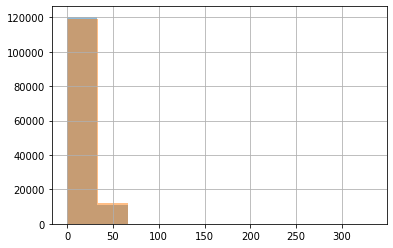

In [25]:
fig = plt.figure()
ax = fig.add_subplot()
train_df["target_delta_distance"].hist(ax=ax, alpha=0.5)
train_df["delta_distance"].hist(ax=ax, alpha=0.5)

<AxesSubplot:>

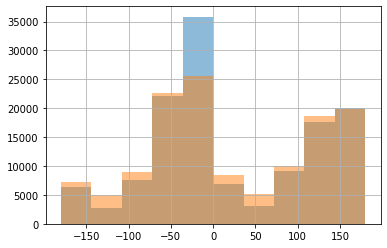

In [24]:
fig = plt.figure()
ax = fig.add_subplot()
train_df["target_delta_angle"].hist(ax=ax, alpha=0.5)
train_df["delta_angle"].hist(ax=ax, alpha=0.5)

In [26]:
train_df[['target_delta_angle','delta_angle']]

,target_delta_angle,delta_angle
0,0.000000,0.000000
1,-10.008102,-14.036243
2,-108.103827,23.962489
3,-97.989318,-42.357455
4,-80.819484,155.674425
...,...,...
131337,-90.000000,-165.033280
131338,-90.000000,-143.627353
131339,-46.735758,-53.615648
131340,94.358216,-165.196020


In [27]:
(train_df["target_delta_angle"].dropna() - train_df["delta_angle"].dropna()).abs().mean()

32.0923381988382

In [28]:
train_imu_df = utils.from_pickle(root_dir / 'imu_dataset_v3/train.pkl')
test_imu_df = utils.from_pickle(root_dir / 'imu_dataset_v3/test.pkl')

In [29]:
assert train_df.shape[0]==train_imu_df.shape[0]
assert test_df.shape[0]==test_imu_df.shape[0]

In [30]:
# 現時点でのdeltaを特徴量として追加するのは良いかも
train_df = train_df[['collectionName', 'phoneName', 'millisSinceGpsEpoch', 'delta_latDeg', 'delta_lngDeg', 'delta_distance', 'target_delta_latDeg', 'target_delta_lngDeg', 'target_delta_distance']]
test_df = test_df[['collectionName', 'phoneName', 'millisSinceGpsEpoch']]

In [31]:
train_df = train_df.merge(train_imu_df, on=['collectionName', 'phoneName', 'millisSinceGpsEpoch'])
test_df = train_df.merge(test_imu_df, on=['collectionName', 'phoneName', 'millisSinceGpsEpoch'])

## preprocessing

In [32]:
whole_df = pd.concat([train_df, test_df]).reset_index(drop=True)
collection_size = whole_df['collectionName'].nunique()
phone_size = whole_df['phoneName'].nunique()

le_co = LabelEncoder()
le_co.fit(whole_df['collectionName'])
le_ph = LabelEncoder()
le_ph.fit(whole_df['phoneName'])


def preprocess(input_df, le1=le_co, le2=le_ph):
    output_df = input_df.copy()
    
    # LE
    output_df['le_collectionName'] = le1.transform(input_df['collectionName'])
    output_df['le_phoneName'] = le2.transform(input_df['phoneName'])
    return output_df

train_df = preprocess(train_df)
test_df = preprocess(test_df)

## model

In [49]:

params = {
    # 目的関数. これの意味で最小となるようなパラメータを探します. 
    'objective': 'rmse', 
    'metric':'rmse',

     # 学習率. 小さいほどなめらかな決定境界が作られて性能向上に繋がる場合が多いです、
    # がそれだけ木を作るため学習に時間がかかります
    'learning_rate': .01,

    # L2 Reguralization
    'reg_lambda': 1.,
    # こちらは L1 
    'reg_alpha': .1,

    # 木の深さ. 深い木を許容するほどより複雑な交互作用を考慮するようになります
    'max_depth': 5, 

    # 木の最大数. early_stopping という枠組みで木の数は制御されるようにしていますのでとても大きい値を指定しておきます.
    'n_estimators': 10000, 

    # 木を作る際に考慮する特徴量の割合. 1以下を指定すると特徴をランダムに欠落させます。小さくすることで, まんべんなく特徴を使うという効果があります.
    'colsample_bytree': .5,

    # 最小分割でのデータ数. 小さいとより細かい粒度の分割方法を許容します.
    'min_child_samples': 10,

    # bagging の頻度と割合
    'subsample_freq': 3,
    'subsample': .9,

    # 特徴重要度計算のロジック(後述)
    'importance_type': 'gain', 
    'random_state': 71,
}

In [50]:
# os.makedirs(f'../../model/{EXP_NAME}', exist_ok=True)

## train

In [51]:

import lightgbm as lgbm
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error
from wandb.lightgbm import wandb_callback

def fit_lgbm(X, 
             y, 
             params: dict=None, 
             verbose: int=50):
    """lightGBM を CrossValidation の枠組みで学習を行なう function"""
    # パラメータがないときは、空の dict で置き換える
    if params is None:
        params = {}

    oofs = []  # 全てのoofをdfで格納する
    predictions = []  # 全ての予測値をdfで格納する
    val_scores = []

    skf = model_selection.StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
    train_fold = [(trn_idx, val_idx) for trn_idx, val_idx in skf.split(X, X['le_collectionName'])]
    for fold in range(5):
        # 指定したfoldのみループを回す
        if fold not in USE_FOLDS:
            continue

        print('=' * 20)
        print(f'Fold {fold}')
        print('=' * 20)


        # training data の target と同じだけのゼロ配列を用意
        oof_pred = np.zeros_like(y, dtype=np.float)

        # train/valid data
        trn_idx_for_train, val_idx_for_train = train_fold[fold]
        x_train = X.loc[trn_idx_for_train, :].reset_index(drop=True)
        x_valid = X.loc[val_idx_for_train, :].reset_index(drop=True)
        y_train = y.loc[trn_idx_for_train].reset_index(drop=True)
        y_valid = y.loc[val_idx_for_train].reset_index(drop=True)
        
        # clf = MultiOutputRegressor(lgbm.LGBMRegressor(**params))
        clf = lgbm.LGBMRegressor(**params)

        # loggers
        RUN_NAME = EXP_NAME + "_" + EXP_MESSAGE
        wandb.init(project='outdoor', entity='kuto5046', group=RUN_NAME)
        wandb.run.name = RUN_NAME + f'-fold-{fold}'
        wandb_config = wandb.config
        wandb_config['model_name'] = "lightGBM"
        wandb_config['comment'] = NOTES
        # wandb.watch(clf)
        
        with utils.Timer(prefix='fit fold={} '.format(fold)):
            clf.fit(x_train, y_train,
                    eval_set=[(x_valid, y_valid)],  
                    early_stopping_rounds=100,
                    verbose=verbose,
                    callbacks=[wandb_callback()])

        pred_i = clf.predict(x_valid)
        oof_pred[val_idx_for_train] = pred_i


        # models.append(clf)
        score = mean_squared_error(y_valid, pred_i) ** .5
        val_scores.append(score)
        print(f'Fold {fold} MSE: {score:.4f}')

        if fold!=4:
            wandb.finish()
    
    all_score = mean_squared_error(y, oof_pred) ** .5
    print('-' * 50)
    print('FINISHED | Whole MSE: {:.4f}'.format(all_score))
    features = x_train.columns.values
    return oof_pred

In [52]:
# latitude
y = train_df["target_delta_latDeg"]
X = train_df.drop(['target_delta_latDeg','target_delta_lngDeg','target_delta_distance', 'collectionName', 'phoneName'], axis=1)
oof_lat = fit_lgbm(X, y, params=params, verbose=50)


Fold 0


valid_0_l2,0.0
_runtime,17
_timestamp,1622636179
_step,980


valid_0_l2,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇███
_timestamp,▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: wandb version 0.10.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Training until validation scores don't improve for 100 rounds
[50]	valid_0's rmse: 0.000101535
[100]	valid_0's rmse: 7.84653e-05
[150]	valid_0's rmse: 6.30217e-05
[200]	valid_0's rmse: 5.12949e-05
[250]	valid_0's rmse: 4.45951e-05
[300]	valid_0's rmse: 3.97769e-05
[350]	valid_0's rmse: 3.64896e-05
[400]	valid_0's rmse: 3.47521e-05
[450]	valid_0's rmse: 3.35621e-05
[500]	valid_0's rmse: 3.24121e-05
[550]	valid_0's rmse: 3.172e-05
[600]	valid_0's rmse: 3.10167e-05
[650]	valid_0's rmse: 3.04516e-05
[700]	valid_0's rmse: 2.99356e-05
[750]	valid_0's rmse: 2.94234e-05
[800]	valid_0's rmse: 2.90146e-05
[850]	valid_0's rmse: 2.87112e-05
[900]	valid_0's rmse: 2.84205e-05
[950]	valid_0's rmse: 2.82049e-05
[1000]	valid_0's rmse: 2.79477e-05
[1050]	valid_0's rmse: 2.77411e-05
[1100]	valid_0's rmse: 2.7535e-05
[1150]	valid_0's rmse: 2.73685e-05
[1200]	valid_0's rmse: 2.7

valid_0_rmse,3e-05
_runtime,39
_timestamp,1622637527
_step,2514


valid_0_rmse,█▆▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


Fold 1


wandb: wandb version 0.10.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Training until validation scores don't improve for 100 rounds
[50]	valid_0's rmse: 0.000102255
[100]	valid_0's rmse: 7.93037e-05
[150]	valid_0's rmse: 6.39978e-05
[200]	valid_0's rmse: 5.25066e-05
[250]	valid_0's rmse: 4.59548e-05
[300]	valid_0's rmse: 4.1324e-05
[350]	valid_0's rmse: 3.81951e-05
[400]	valid_0's rmse: 3.65554e-05
[450]	valid_0's rmse: 3.54285e-05
[500]	valid_0's rmse: 3.43446e-05
[550]	valid_0's rmse: 3.37001e-05
[600]	valid_0's rmse: 3.30497e-05
[650]	valid_0's rmse: 3.25417e-05
[700]	valid_0's rmse: 3.20665e-05
[750]	valid_0's rmse: 3.16254e-05
[800]	valid_0's rmse: 3.12624e-05
[850]	valid_0's rmse: 3.09949e-05
[900]	valid_0's rmse: 3.07412e-05
[950]	valid_0's rmse: 3.05506e-05
[1000]	valid_0's rmse: 3.03196e-05
[1050]	valid_0's rmse: 3.01306e-05
[1100]	valid_0's rmse: 2.99511e-05
[1150]	valid_0's rmse: 2.98142e-05
[1200]	valid_0's rmse: 2

valid_0_rmse,3e-05
_runtime,34
_timestamp,1622637565
_step,2198


valid_0_rmse,█▆▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█████
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


Fold 2


wandb: wandb version 0.10.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Training until validation scores don't improve for 100 rounds
[50]	valid_0's rmse: 0.000101667
[100]	valid_0's rmse: 7.86344e-05
[150]	valid_0's rmse: 6.3167e-05
[200]	valid_0's rmse: 5.14762e-05
[250]	valid_0's rmse: 4.47419e-05
[300]	valid_0's rmse: 3.99583e-05
[350]	valid_0's rmse: 3.66917e-05
[400]	valid_0's rmse: 3.4967e-05
[450]	valid_0's rmse: 3.37834e-05
[500]	valid_0's rmse: 3.26296e-05
[550]	valid_0's rmse: 3.19427e-05
[600]	valid_0's rmse: 3.12521e-05
[650]	valid_0's rmse: 3.07014e-05
[700]	valid_0's rmse: 3.0193e-05
[750]	valid_0's rmse: 2.97332e-05
[800]	valid_0's rmse: 2.93252e-05
[850]	valid_0's rmse: 2.90279e-05
[900]	valid_0's rmse: 2.87522e-05
[950]	valid_0's rmse: 2.8539e-05
[1000]	valid_0's rmse: 2.8289e-05
[1050]	valid_0's rmse: 2.80772e-05
[1100]	valid_0's rmse: 2.78754e-05
[1150]	valid_0's rmse: 2.77178e-05
[1200]	valid_0's rmse: 2.758

valid_0_rmse,3e-05
_runtime,40
_timestamp,1622637609
_step,2685


valid_0_rmse,█▅▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


Fold 3


wandb: wandb version 0.10.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Training until validation scores don't improve for 100 rounds
[50]	valid_0's rmse: 0.000103266
[100]	valid_0's rmse: 8.07304e-05
[150]	valid_0's rmse: 6.58181e-05
[200]	valid_0's rmse: 5.46437e-05
[250]	valid_0's rmse: 4.83782e-05
[300]	valid_0's rmse: 4.39872e-05
[350]	valid_0's rmse: 4.10269e-05
[400]	valid_0's rmse: 3.94876e-05
[450]	valid_0's rmse: 3.84457e-05
[500]	valid_0's rmse: 3.74401e-05
[550]	valid_0's rmse: 3.68306e-05
[600]	valid_0's rmse: 3.62403e-05
[650]	valid_0's rmse: 3.57752e-05
[700]	valid_0's rmse: 3.53402e-05
[750]	valid_0's rmse: 3.49205e-05
[800]	valid_0's rmse: 3.45797e-05
[850]	valid_0's rmse: 3.43132e-05
[900]	valid_0's rmse: 3.40728e-05
[950]	valid_0's rmse: 3.38873e-05
[1000]	valid_0's rmse: 3.36823e-05
[1050]	valid_0's rmse: 3.35133e-05
[1100]	valid_0's rmse: 3.33505e-05
[1150]	valid_0's rmse: 3.32116e-05
[1200]	valid_0's rmse: 

valid_0_rmse,3e-05
_runtime,130
_timestamp,1622637743
_step,9999


valid_0_rmse,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


Fold 4


wandb: wandb version 0.10.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Training until validation scores don't improve for 100 rounds
[50]	valid_0's rmse: 0.000104224
[100]	valid_0's rmse: 7.74796e-05
[150]	valid_0's rmse: 6.33785e-05
[200]	valid_0's rmse: 5.33565e-05
[250]	valid_0's rmse: 4.59658e-05
[300]	valid_0's rmse: 4.10113e-05
[350]	valid_0's rmse: 3.78546e-05
[400]	valid_0's rmse: 3.59345e-05
[450]	valid_0's rmse: 3.40435e-05
[500]	valid_0's rmse: 3.32173e-05
[550]	valid_0's rmse: 3.25045e-05
[600]	valid_0's rmse: 3.19591e-05
[650]	valid_0's rmse: 3.14798e-05
[700]	valid_0's rmse: 3.09274e-05
[750]	valid_0's rmse: 3.03671e-05
[800]	valid_0's rmse: 2.97853e-05
[850]	valid_0's rmse: 2.93549e-05
[900]	valid_0's rmse: 2.90274e-05
[950]	valid_0's rmse: 2.86752e-05
[1000]	valid_0's rmse: 2.8462e-05
[1050]	valid_0's rmse: 2.81982e-05
[1100]	valid_0's rmse: 2.79629e-05
[1150]	valid_0's rmse: 2.77731e-05
[1200]	valid_0's rmse: 2

In [53]:
# longitude
y = train_df["target_delta_lngDeg"]
# X = train_df.drop(['target_delta_latDeg','target_delta_lngDeg','target_delta_distance', 'collectionName', 'phoneName'], axis=1)
oof_lng = fit_lgbm(X, y, params=params, verbose=50)

Fold 0


valid_0_rmse,3e-05
_runtime,98
_timestamp,1622637845
_step,7377


valid_0_rmse,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: wandb version 0.10.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Training until validation scores don't improve for 100 rounds
[50]	valid_0's rmse: 0.000125195
[100]	valid_0's rmse: 9.5902e-05
[150]	valid_0's rmse: 7.52309e-05
[200]	valid_0's rmse: 6.11277e-05
[250]	valid_0's rmse: 5.32949e-05
[300]	valid_0's rmse: 4.7174e-05
[350]	valid_0's rmse: 4.41392e-05
[400]	valid_0's rmse: 4.18548e-05
[450]	valid_0's rmse: 4.02615e-05
[500]	valid_0's rmse: 3.87183e-05
[550]	valid_0's rmse: 3.76229e-05
[600]	valid_0's rmse: 3.70516e-05
[650]	valid_0's rmse: 3.64836e-05
[700]	valid_0's rmse: 3.59522e-05
[750]	valid_0's rmse: 3.53764e-05
[800]	valid_0's rmse: 3.4908e-05
[850]	valid_0's rmse: 3.45467e-05
[900]	valid_0's rmse: 3.4203e-05
[950]	valid_0's rmse: 3.39539e-05
[1000]	valid_0's rmse: 3.36875e-05
[1050]	valid_0's rmse: 3.34804e-05
[1100]	valid_0's rmse: 3.32983e-05
[1150]	valid_0's rmse: 3.30802e-05
[1200]	valid_0's rmse: 3.29

valid_0_rmse,3e-05
_runtime,135
_timestamp,1622638092
_step,9999


valid_0_rmse,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


Fold 1


wandb: wandb version 0.10.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Training until validation scores don't improve for 100 rounds
[50]	valid_0's rmse: 0.000124761
[100]	valid_0's rmse: 9.57669e-05
[150]	valid_0's rmse: 7.52824e-05
[200]	valid_0's rmse: 6.13458e-05
[250]	valid_0's rmse: 5.36012e-05
[300]	valid_0's rmse: 4.76333e-05
[350]	valid_0's rmse: 4.46794e-05
[400]	valid_0's rmse: 4.24949e-05
[450]	valid_0's rmse: 4.09417e-05
[500]	valid_0's rmse: 3.94207e-05
[550]	valid_0's rmse: 3.83779e-05
[600]	valid_0's rmse: 3.78332e-05
[650]	valid_0's rmse: 3.72769e-05
[700]	valid_0's rmse: 3.67507e-05
[750]	valid_0's rmse: 3.61917e-05
[800]	valid_0's rmse: 3.57525e-05
[850]	valid_0's rmse: 3.54322e-05
[900]	valid_0's rmse: 3.51056e-05
[950]	valid_0's rmse: 3.48548e-05
[1000]	valid_0's rmse: 3.45999e-05
[1050]	valid_0's rmse: 3.43893e-05
[1100]	valid_0's rmse: 3.42097e-05
[1150]	valid_0's rmse: 3.39972e-05
[1200]	valid_0's rmse: 

valid_0_rmse,3e-05
_runtime,63
_timestamp,1622638159
_step,4048


valid_0_rmse,█▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


Fold 2


wandb: wandb version 0.10.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Training until validation scores don't improve for 100 rounds
[50]	valid_0's rmse: 0.000124637
[100]	valid_0's rmse: 9.56077e-05
[150]	valid_0's rmse: 7.50568e-05
[200]	valid_0's rmse: 6.10454e-05
[250]	valid_0's rmse: 5.32861e-05
[300]	valid_0's rmse: 4.72978e-05
[350]	valid_0's rmse: 4.4362e-05
[400]	valid_0's rmse: 4.21606e-05
[450]	valid_0's rmse: 4.06143e-05
[500]	valid_0's rmse: 3.90649e-05
[550]	valid_0's rmse: 3.80164e-05
[600]	valid_0's rmse: 3.7467e-05
[650]	valid_0's rmse: 3.69042e-05
[700]	valid_0's rmse: 3.63982e-05
[750]	valid_0's rmse: 3.58336e-05
[800]	valid_0's rmse: 3.53779e-05
[850]	valid_0's rmse: 3.50263e-05
[900]	valid_0's rmse: 3.46958e-05
[950]	valid_0's rmse: 3.44405e-05
[1000]	valid_0's rmse: 3.41796e-05
[1050]	valid_0's rmse: 3.39778e-05
[1100]	valid_0's rmse: 3.37841e-05
[1150]	valid_0's rmse: 3.3574e-05
[1200]	valid_0's rmse: 3.3

valid_0_rmse,3e-05
_runtime,101
_timestamp,1622638266
_step,7194


valid_0_rmse,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
_timestamp,▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


Fold 3


wandb: wandb version 0.10.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Training until validation scores don't improve for 100 rounds
[50]	valid_0's rmse: 0.000124647
[100]	valid_0's rmse: 9.60737e-05
[150]	valid_0's rmse: 7.60142e-05
[200]	valid_0's rmse: 6.24833e-05
[250]	valid_0's rmse: 5.50526e-05
[300]	valid_0's rmse: 4.93775e-05
[350]	valid_0's rmse: 4.6587e-05
[400]	valid_0's rmse: 4.45051e-05
[450]	valid_0's rmse: 4.30411e-05
[500]	valid_0's rmse: 4.15839e-05
[550]	valid_0's rmse: 4.06111e-05
[600]	valid_0's rmse: 4.00734e-05
[650]	valid_0's rmse: 3.95523e-05
[700]	valid_0's rmse: 3.90696e-05
[750]	valid_0's rmse: 3.85577e-05
[800]	valid_0's rmse: 3.81347e-05
[850]	valid_0's rmse: 3.78102e-05
[900]	valid_0's rmse: 3.74928e-05
[950]	valid_0's rmse: 3.72648e-05
[1000]	valid_0's rmse: 3.70219e-05
[1050]	valid_0's rmse: 3.68316e-05
[1100]	valid_0's rmse: 3.66572e-05
[1150]	valid_0's rmse: 3.64634e-05
[1200]	valid_0's rmse: 3

valid_0_rmse,3e-05
_runtime,135
_timestamp,1622638405
_step,9999


valid_0_rmse,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


Fold 4


wandb: wandb version 0.10.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Training until validation scores don't improve for 100 rounds
[50]	valid_0's rmse: 0.000123924
[100]	valid_0's rmse: 9.02408e-05
[150]	valid_0's rmse: 7.17074e-05
[200]	valid_0's rmse: 5.80115e-05
[250]	valid_0's rmse: 4.98145e-05
[300]	valid_0's rmse: 4.44487e-05
[350]	valid_0's rmse: 4.18927e-05
[400]	valid_0's rmse: 3.97579e-05
[450]	valid_0's rmse: 3.83354e-05
[500]	valid_0's rmse: 3.69365e-05
[550]	valid_0's rmse: 3.58619e-05
[600]	valid_0's rmse: 3.50377e-05
[650]	valid_0's rmse: 3.4487e-05
[700]	valid_0's rmse: 3.40076e-05
[750]	valid_0's rmse: 3.36645e-05
[800]	valid_0's rmse: 3.34316e-05
[850]	valid_0's rmse: 3.32046e-05
[900]	valid_0's rmse: 3.29449e-05
[950]	valid_0's rmse: 3.26913e-05
[1000]	valid_0's rmse: 3.25539e-05
[1050]	valid_0's rmse: 3.23301e-05
[1100]	valid_0's rmse: 3.21512e-05
[1150]	valid_0's rmse: 3.19809e-05
[1200]	valid_0's rmse: 3

## validation

In [54]:
train_df['oof_delta_lngDeg'] = oof_lng
train_df['oof_delta_latDeg'] = oof_lat

In [55]:
train_df

,collectionName,phoneName,millisSinceGpsEpoch,delta_latDeg,delta_lngDeg,delta_distance,target_delta_latDeg,target_delta_lngDeg,target_delta_distance,accx_0,...,gyroz_94,gyroz_95,gyroz_96,gyroz_97,gyroz_98,gyroz_99,le_collectionName,le_phoneName,oof_delta_lngDeg,oof_delta_latDeg
0,2020-05-14-US-MTV-1,Pixel4,1273529463442,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0.000000,0.000000
1,2020-05-14-US-MTV-1,Pixel4,1273529464442,0.000002,-0.000010,0.888202,2.999982e-10,-1.700002e-09,0.000154,0.285826,...,-0.005614,0.021370,0.013379,-0.004650,-0.003194,0.007943,0,1,-0.000019,0.000012
2,2020-05-14-US-MTV-1,Pixel4,1273529465442,-0.000004,-0.000010,1.001204,1.040000e-08,3.400004e-09,0.001194,0.510429,...,0.010015,-0.003458,-0.010163,0.007554,0.018602,-0.007325,0,1,0.000000,0.000000
3,2020-05-14-US-MTV-1,Pixel4,1273529466442,0.000009,-0.000010,1.370528,1.140000e-08,1.600000e-09,0.001275,0.328562,...,-0.004991,-0.004373,0.002696,-0.004647,-0.030105,-0.020775,0,1,0.000000,0.000000
4,2020-05-14-US-MTV-1,Pixel4,1273529467442,-0.000003,0.000007,0.741296,9.900006e-09,-1.600000e-09,0.001109,0.097918,...,0.003267,0.011595,-0.012660,-0.020949,-0.005216,0.008465,0,1,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131337,2021-04-29-US-SJC-2,SamsungS20Ultra,1303760315000,0.000003,0.000010,0.941490,5.000004e-09,0.000000e+00,0.000556,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,28,6,0.000000,0.000000
131338,2021-04-29-US-SJC-2,SamsungS20Ultra,1303760316000,0.000012,0.000017,2.011345,4.999997e-09,0.000000e+00,0.000556,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,28,6,0.000000,0.000000
131339,2021-04-29-US-SJC-2,SamsungS20Ultra,1303760317000,0.000019,-0.000014,2.447052,1.700002e-09,-1.600000e-09,0.000236,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,28,6,0.000000,0.000000
131340,2021-04-29-US-SJC-2,SamsungS20Ultra,1303760318000,0.000004,0.000014,1.303535,-4.330000e-08,3.300002e-09,0.004821,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,28,6,0.000000,0.000000


In [57]:
# waypoint補正前のx,yでの評価
oof_score = mean_squared_error(
    train_df['oof_delta_lngDeg'], train_df['target_delta_lngDeg'], squared=False
    )

print(f"CV:{oof_score}")

# waypoint補正前のx,yでの評価
oof_score = mean_squared_error(
    train_df['oof_delta_latDeg'], train_df['target_delta_latDeg'], squared=False
    )

print(f"CV:{oof_score}")

CV:0.0001589717284266239
CV:0.00012814614903903208
